In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import shap


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
os.chdir('D:/repo/AlgoUtil') # Use your own path
from common import get_data_path
from get_data.static import RESTfulProcessor

In [4]:
from get_data.static import RESTfulProcessor
resp = RESTfulProcessor(verbose=False)
df_train, df_test = resp.process_data()

2021-11-05 16:23:33,824 INFO: Found stored D:\repo\AlgoUtil/data/ticker.pkl data, start loading
2021-11-05 16:23:33,829 INFO: Loading is done
2021-11-05 16:23:33,831 INFO: Found stored D:\repo\AlgoUtil/data/ticker_detail.pkl data, start loading
2021-11-05 16:23:33,871 INFO: Loading is done
2021-11-05 16:23:33,872 INFO: Found stored D:\repo\AlgoUtil/data/ticker_price.pkl data, start loading
2021-11-05 16:23:33,987 INFO: Loading is done


In [5]:
df_all = pd.concat([df_train, df_test], ignore_index=True)

sample_tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOG', 'TSLA', 'NVDA']
df_model = df_all[df_all['ticker'].isin(sample_tickers)]
df_ohe = pd.get_dummies(df_model['ticker'], drop_first=True)
df_model = df_model.join(df_ohe)

df_model = df_model[[
    'date', 'ticker', 'after_hours', 'high', 'low', 'open', 'close', 'pre_market', 'volume', 'last_after_hours',
    'after_hours_chg', 'after_hours_pct_chg', 'last_pre_market', 'pre_market_chg', 'pre_market_pct_chg',
    'last_volume', 'volume_chg', 'volume_pct_chg', 'last_open', 'open_chg', 'open_pct_chg', 'last_close',
    'close_chg', 'close_pct_chg', 'MSFT', 'AMZN', 'FB', 'GOOG', 'TSLA', 'NVDA'
]]
df_model.dropna(inplace=True)

cutoff = datetime.datetime.strptime('2021-08-01', '%Y-%m-%d').date()
df_train = df_model[df_model['date'] < cutoff].copy()
df_test = df_model[df_model['date'] >= cutoff].copy()
X_cols = ['after_hours', 'high', 'low', 'open', 'MSFT', 'AMZN', 'FB', 'GOOG', 'TSLA', 'NVDA']

# Decision Tree

In [6]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor().fit(df_train[X_cols], df_train['close'])
print('untuned score: ', clf.score(df_train[X_cols], df_train['close']))
clf = DecisionTreeRegressor(splitter='random', max_depth=5, min_samples_split=16, min_samples_leaf=10).fit(
    df_train[X_cols], df_train['close'])
print('tuned score: ', clf.score(df_train[X_cols], df_train['close']))


untuned score:  1.0
tuned score:  0.9994473879702526


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


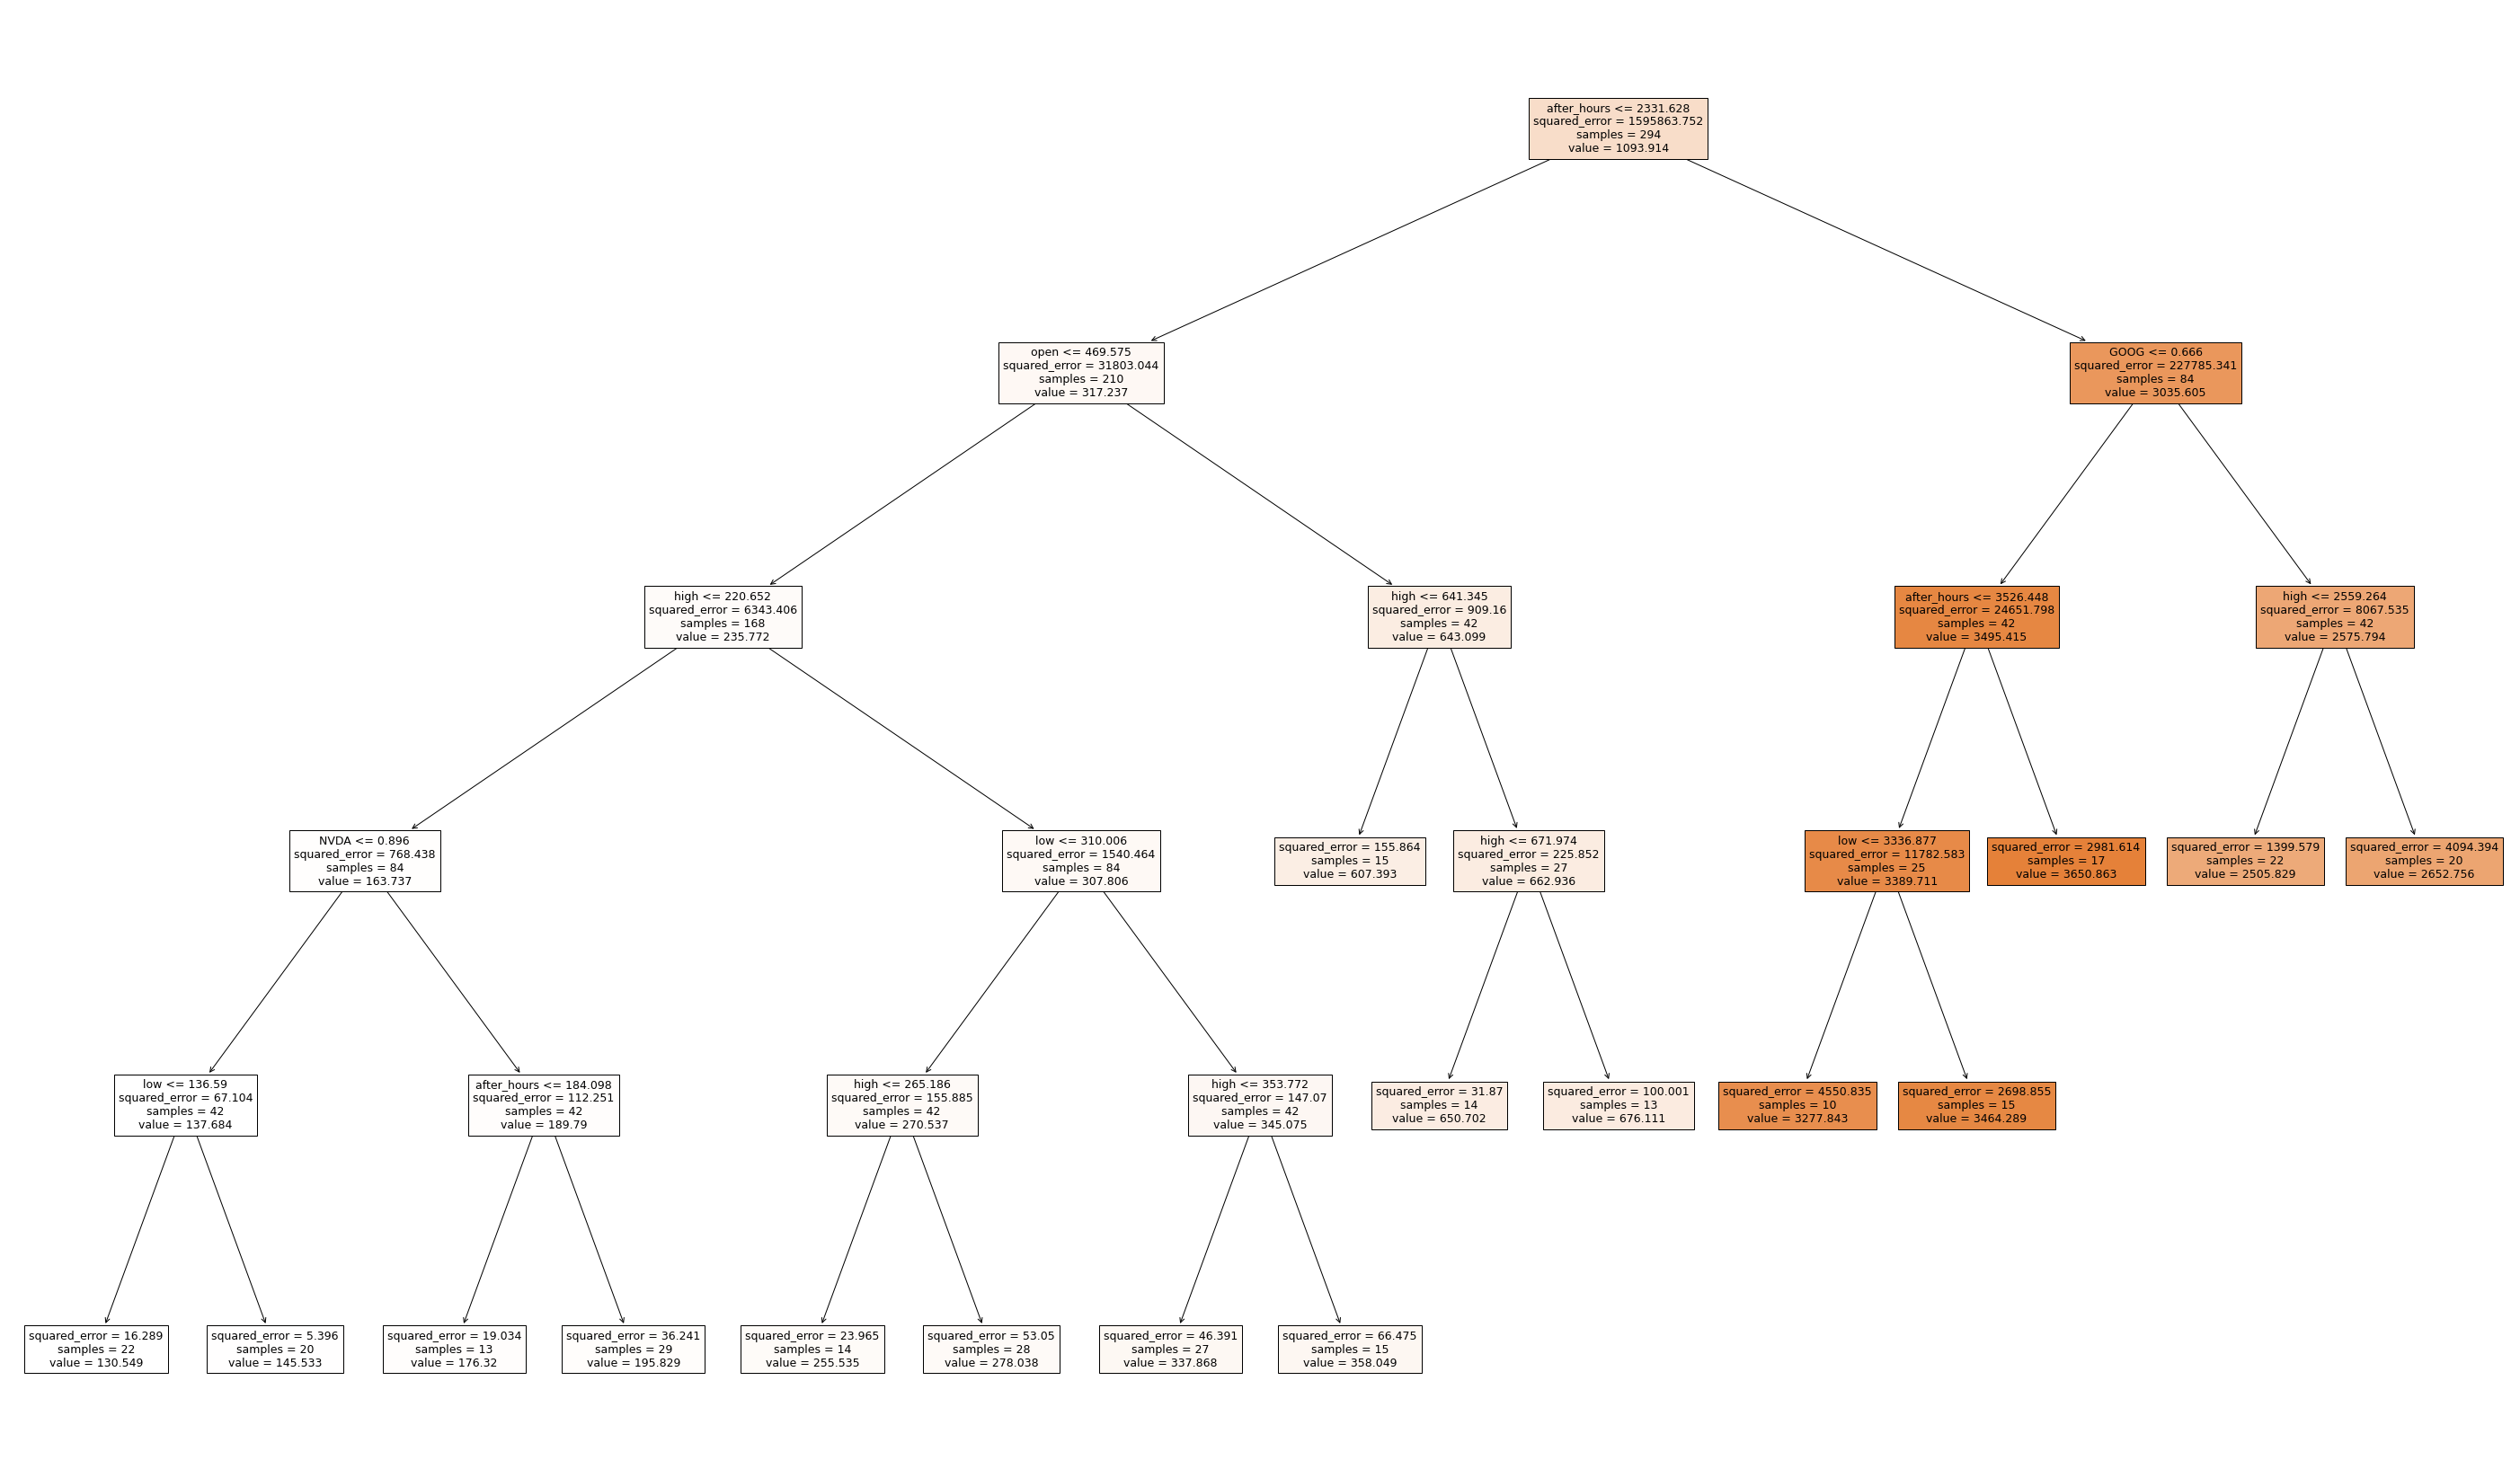

In [7]:
fig = plt.figure(figsize=(50, 30))
_ = tree.plot_tree(clf, feature_names=X_cols, class_names='close', filled=True)
fig.show()

# SHAP

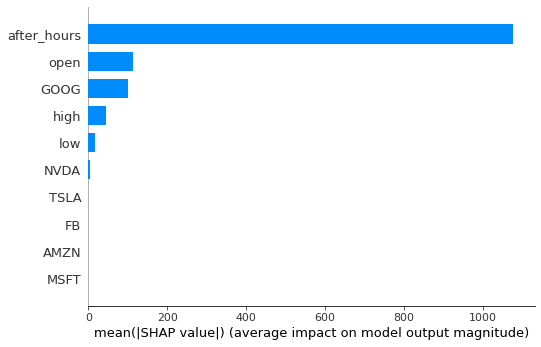

In [8]:
shap.initjs()
explainer = shap.TreeExplainer(clf, df_train[X_cols])
# shap_values = explainer(df_train[X_cols])

shap_values = explainer.shap_values(df_test[X_cols])[0]
p = shap.force_plot(explainer.expected_value, shap_values, df_test[X_cols].iloc[0].values)

shap_values = explainer.shap_values(df_test[X_cols])
shap.summary_plot(shap_values, df_test[X_cols], plot_type='bar')

# Waterfall Force Plot

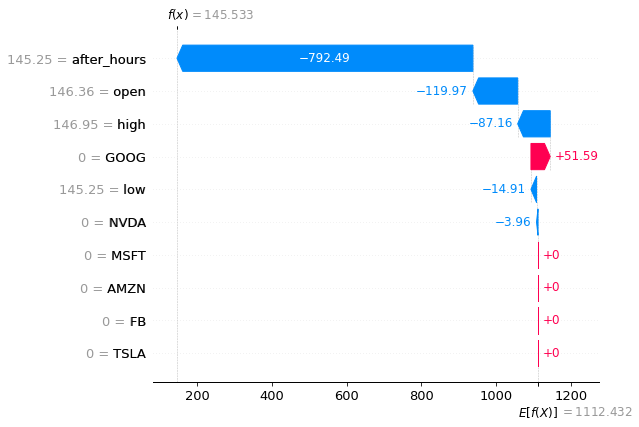

In [9]:
# visualize the first prediction's explanation
shap_values = explainer(df_test[X_cols])
shap.plots.waterfall(shap_values[0])

# Decision Plot

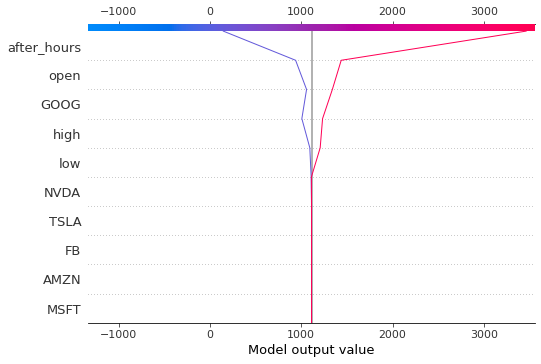

In [10]:
explainer = shap.TreeExplainer(clf, df_train[X_cols])
shap_values = explainer.shap_values(df_test[X_cols])
shap.decision_plot(explainer.expected_value, shap_values[[1, 76]], df_test[X_cols].iloc[[1, 76]])

# Feature Importance

Feature: after_hours, Score: 0.9469855320985158
Feature: high, Score: 0.0024324940063218652
Feature: low, Score: 0.0006986204315927653
Feature: open, Score: 0.01188839651757233
Feature: MSFT, Score: 0.0
Feature: AMZN, Score: 0.0
Feature: FB, Score: 0.0
Feature: GOOG, Score: 0.03787336834051165
Feature: TSLA, Score: 0.0
Feature: NVDA, Score: 0.00012158860548573496


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


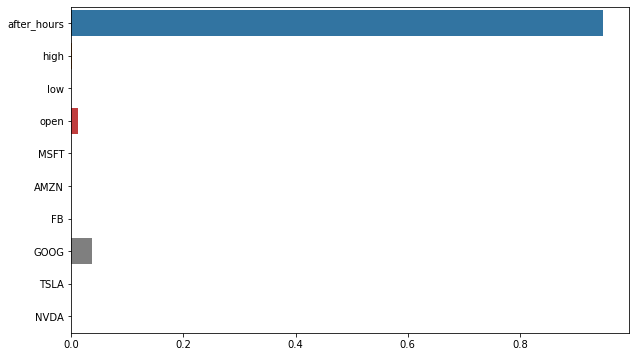

In [11]:
importance = clf.feature_importances_
# summarize feature importance
fig2, ax2 = plt.subplots(figsize=(10, 6))
for f, s in zip(X_cols, importance):
    print('Feature: {f}, Score: {s}'.format(f=f, s=s))
# plot feature importance
ax2 = sns.barplot(x=importance, y=X_cols)
fig2.show()

# ExtraTrees

In [12]:
from sklearn.ensemble import ExtraTreesRegressor
extra_trees = ExtraTreesRegressor().fit(df_train[X_cols], df_train['close'])
print('untuned score: ', extra_trees.score(df_train[X_cols], df_train['close']))
extra_trees = ExtraTreesRegressor(max_depth=23, min_samples_split=16, min_samples_leaf=5, n_jobs=-1).fit(df_train[X_cols], df_train['close'])
print('tuned score: ', extra_trees.score(df_train[X_cols], df_train['close']))

for f, s in zip(X_cols, extra_trees.feature_importances_):
    print('Feature: {f}, Score: {s}'.format(f=f, s=s))

untuned score:  1.0
tuned score:  0.9998963820883858
Feature: after_hours, Score: 0.24974157171240727
Feature: high, Score: 0.2594200238480432
Feature: low, Score: 0.254868542092305
Feature: open, Score: 0.1894773318849334
Feature: MSFT, Score: 0.00017968125913058686
Feature: AMZN, Score: 0.011738324524432343
Feature: FB, Score: 0.00016368412552898772
Feature: GOOG, Score: 0.027557963882931694
Feature: TSLA, Score: 0.006775134325884608
Feature: NVDA, Score: 7.774234440293288e-05


# Random Forest

In [13]:
seed = 4657514
from sklearn.ensemble import RandomForestRegressor
rf_mod = RandomForestRegressor(n_estimators=150, min_samples_leaf=15, oob_score=True, random_state=seed, ccp_alpha=0.08)
rf_mod.fit(df_train[X_cols].values, df_train['close'].values)
print('untuned score: ', rf_mod.score(df_train[X_cols].values, df_train['close'].values))

rf_weighted = RandomForestRegressor(n_estimators=150, min_samples_leaf=15, oob_score=True, random_state=seed, ccp_alpha=0.08)
rf_weighted.fit(df_train[X_cols].values, df_train['close'].values, sample_weight=np.maximum(1 / df_train['close'].values, 1))
print('weighted score: ', rf_weighted.score(df_train[X_cols].values, df_train['close'].values))

for f, s in zip(X_cols, rf_mod.feature_importances_):
    print('Feature: {f}, Score: {s:.4f}'.format(f=f, s=s))

untuned score:  0.9976096609758451
weighted score:  0.9976096609758451
Feature: after_hours, Score: 0.2427
Feature: high, Score: 0.2304
Feature: low, Score: 0.2231
Feature: open, Score: 0.2878
Feature: MSFT, Score: 0.0001
Feature: AMZN, Score: 0.0060
Feature: FB, Score: 0.0000
Feature: GOOG, Score: 0.0063
Feature: TSLA, Score: 0.0035
Feature: NVDA, Score: 0.0000
